In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from joblib import dump



In [18]:
# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [19]:
# Function to create a dataset for LSTM
def create_dataset(dataset, look_back=3):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [20]:
# Load the training dataset
train_file_path = 'BTC-USD-Training.csv'  
bitcoin_train_data = pd.read_csv(train_file_path)
bitcoin_train_data['Date'] = pd.to_datetime(bitcoin_train_data['Date'])

In [21]:
# Display the number of rows and columns in the dataset
num_rows, num_columns = bitcoin_train_data.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 3416
Number of columns: 7


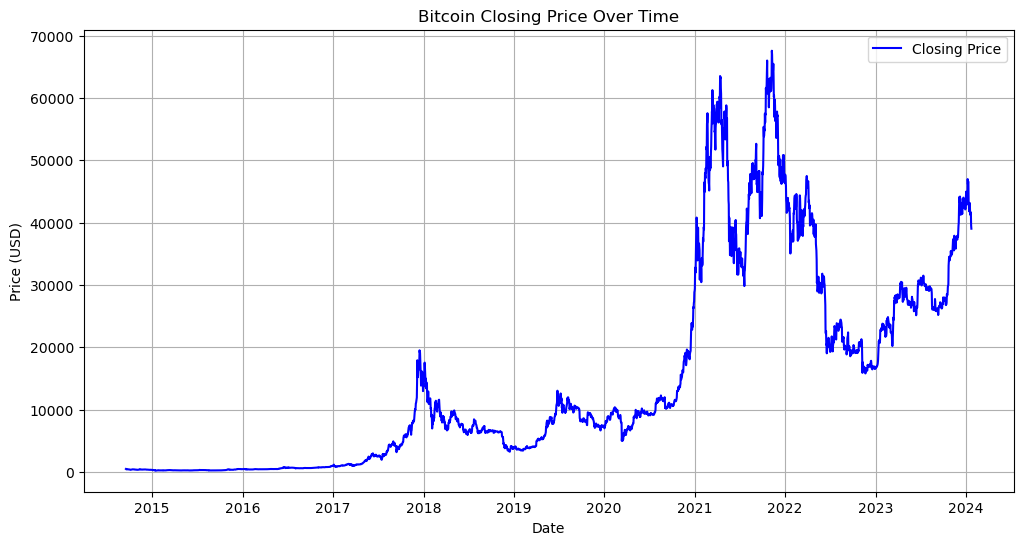

In [22]:
# Plotting the closing price of Bitcoin
plt.figure(figsize=(12,6))
plt.plot(bitcoin_train_data['Date'], bitcoin_train_data['Close'], label='Closing Price', color='b')
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Load the testing dataset
test_file_path = 'BTC-USD-testing.csv'
bitcoin_test_data = pd.read_csv(test_file_path)
bitcoin_test_data['Date'] = pd.to_datetime(bitcoin_test_data['Date'])

In [24]:
# Display the number of rows and columns in the testing dataset
num_rows, num_columns = bitcoin_test_data.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 3416
Number of columns: 7


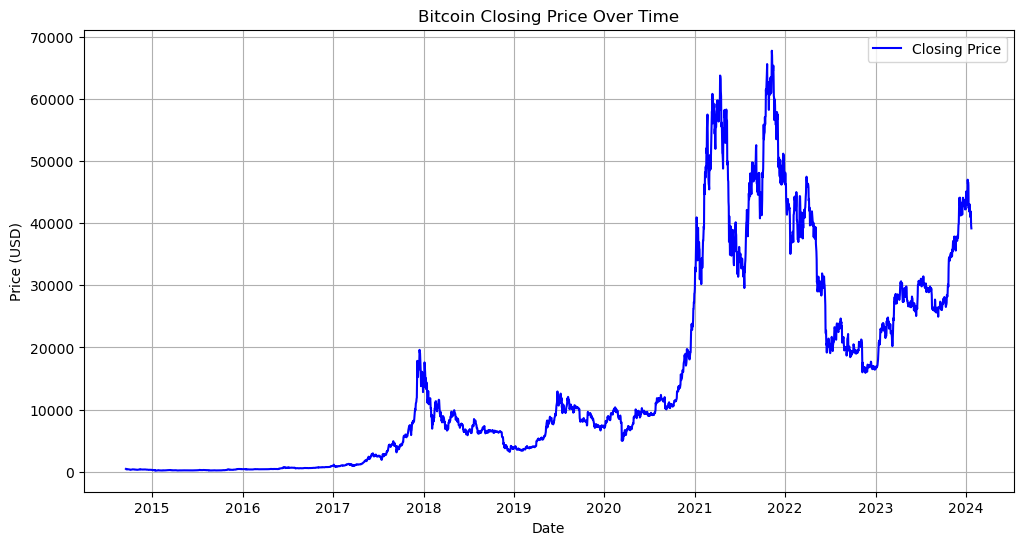

In [25]:
# Plotting the closing price of Bitcoin for testing data
plt.figure(figsize=(12,6))
plt.plot(bitcoin_test_data['Date'], bitcoin_test_data['Close'], label='Closing Price', color='b')
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Normalize the close prices and prepare training and testing datasets
scaler = MinMaxScaler(feature_range=(0, 1))
train_close_prices = scaler.fit_transform(bitcoin_train_data['Close'].values.reshape(-1, 1))
test_close_prices = scaler.transform(bitcoin_test_data['Close'].values.reshape(-1, 1))
look_back = 3
X_train, Y_train = create_dataset(train_close_prices, look_back)
X_test, Y_test = create_dataset(test_close_prices, look_back)


In [27]:
# Build the LSTM model
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [28]:
# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with a validation split
history = model.fit(
    X_train, Y_train,
    epochs=100,  # Increased number of epochs
    batch_size=32,  # Adjusted batch size
    validation_split=0.2,  # 20% of data used for validation
    callbacks=[early_stopping],
    verbose=1
)

# Save the model and scaler
model.save('btc_usd_trained_model.keras')
dump(scaler, 'btc_scaler.bin', compress=True)


Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0293 - val_loss: 3.9350e-04
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8887e-04 - val_loss: 3.2224e-04
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8732e-04 - val_loss: 3.5934e-04
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8292e-04 - val_loss: 2.7985e-04
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0624e-04 - val_loss: 4.4558e-04
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3946e-04 - val_loss: 5.8499e-04
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5911e-04 - val_loss: 3.3936e-04
Epoch 9/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1305e-04 - val_loss: 4.5434e-04
Epoch 10/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7372e-04 - val_loss: 0.0010


['btc_scaler.bin']

In [29]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual price
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [30]:
# Correct calculation for RMSE performance metrics
Y_train_reshaped = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_reshaped = scaler.inverse_transform(Y_test.reshape(-1, 1))

train_rmse = np.sqrt(mean_squared_error(Y_train_reshaped, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test_reshaped, test_predict))

print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)

Train RMSE:  1070.1326883400636
Test RMSE:  1077.4332828655834


In [31]:
# Calculate R² Score for train and test sets
Y_train_inv = scaler.inverse_transform([Y_train])
Y_test_inv = scaler.inverse_transform([Y_test])
train_r2 = r2_score(Y_train_inv[0], train_predict[:,0])
test_r2 = r2_score(Y_test_inv[0], test_predict[:,0])

print("Train R²: ", train_r2)
print("Test R²: ", test_r2)
import matplotlib.dates as mdates

Train R²:  0.9956904332493193
Test R²:  0.9956305539764866


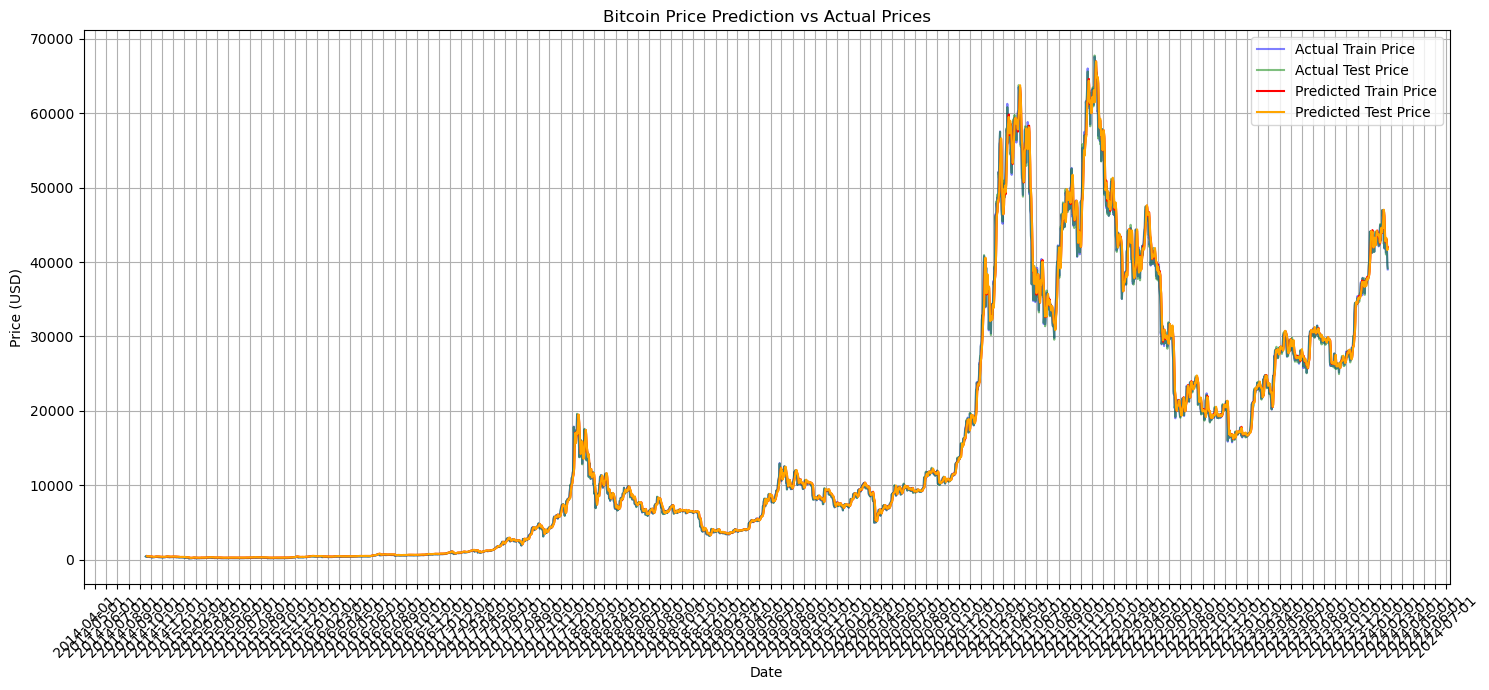

In [32]:
# Assuming bitcoin_train_data and bitcoin_test_data have a 'Date' column in datetime format
# Combine actual train and test dates for plotting
dates_train = bitcoin_train_data['Date'][-len(train_predict):]  # Aligning the length with train_predict
dates_test = bitcoin_test_data['Date'][-len(test_predict):]  # Aligning the length with test_predict

# Plotting the results
fig, ax = plt.subplots(figsize=(15, 7))

# Plot actual prices
ax.plot(bitcoin_train_data['Date'], bitcoin_train_data['Close'], label='Actual Train Price', color='blue', alpha=0.5)
ax.plot(bitcoin_test_data['Date'], bitcoin_test_data['Close'], label='Actual Test Price', color='green', alpha=0.5)

# Plot predicted prices
ax.plot(dates_train, train_predict, label='Predicted Train Price', color='red')
ax.plot(dates_test, test_predict, label='Predicted Test Price', color='orange')

# Formatting the date to make it more readable
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.title('Bitcoin Price Prediction vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjust the plot to ensure it fits nicely
plt.show()